# Starting an automated ML pipeline using the an MLOps environment

Our pipeline was created through the CloudFormation template we deployed at the start of this process.

The pipeline will fire off a number of processes based on CloudFormation and Lambda functions once we trigger it. 

Our pipeline is triggered by putting a zip file with our training parameters, called **trainingjob.zip**, in an S3 bucket. 

CodePipeline will listen to that bucket and then start a job. 

This zip file has the following structure:
 - trainingjob.json (Sagemaker training job descriptor)
 - environment.json (Instructions to the environment of how to deploy and prepare the endpoints)

### Let's start defining the hyperparameters and other attributes


In [2]:
import sagemaker
import boto3
import time
import pandas as pd
import numpy as np

sagemaker_session = sagemaker.Session()

# use_xgboost_builtin=True

sts_client = boto3.client("sts")
account_id = sts_client.get_caller_identity()["Account"]
region = boto3.session.Session().region_name
model_prefix='pipeline'

In [3]:
sagemaker_session.default_bucket()

'sagemaker-us-east-1-641395199407'

We can use our optimal hyperparemters as determed by the hyper parameter tuning job:


In [52]:
# training_image = None
# hyperparameters = None
# if use_xgboost_builtin: 

training_image = sagemaker.image_uris.retrieve('xgboost', boto3.Session().region_name, version='1.0-1')
hyperparameters = {         
    "max_depth":10,
      "eta":0.16510368298823597,
      "gamma":1.2345738417970062,
      "alpha":1.7012053734536687,
      "min_child_weight":4.038526939423086,
      "subsample":0.8,
      "early_stopping_rounds":5,
      "silent":0,
      "objective":'binary:logistic',
      "eval_metric": "auc",
      "num_round":5000} 

# else:

# training_image = '{}.dkr.ecr.{}.amazonaws.com/{}:latest'.format(account_id, region, model_prefix)

# hyperparameters = {
#     "max_depth": 10,
#     "n_jobs": 5,
#     "n_estimators": 120
#     }

# training_image = '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:0.90-2-cpu-py3'

print(training_image)

683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.0-1-cpu-py3


### 1.2 Then, let's  create the trainingjob descriptor

This is a basic template of the input sagemaker requires to build our training and deployment jobs.

In [53]:

roleArn = "arn:aws:iam::{}:role/MLOps".format(account_id)
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
job_name = model_prefix + timestamp
sagemaker_session = sagemaker.Session()

training_params = {}

# Here we set the reference for the Image Classification Docker image, stored on ECR (https://aws.amazon.com/pt/ecr/)
training_params["AlgorithmSpecification"] = {
    "TrainingImage": training_image,
    "TrainingInputMode": "File"
}

# The IAM role with all the permissions given to Sagemaker
training_params["RoleArn"] = roleArn

# Here Sagemaker will store the final trained model
training_params["OutputDataConfig"] = {
    "S3OutputPath": 's3://{}/{}'.format(sagemaker_session.default_bucket(), model_prefix)
}

# This is the config of the instance that will execute the training
training_params["ResourceConfig"] = {
    "InstanceCount": 1,
    "InstanceType": "ml.m4.xlarge",
    "VolumeSizeInGB": 30,
    
}

# The job name. You'll see this name in the Jobs section of the Sagemaker's console
training_params["TrainingJobName"] = job_name

for i in hyperparameters:
    hyperparameters[i] = str(hyperparameters[i])
    
# Here you will configure the hyperparameters used for training your model.
training_params["HyperParameters"] = hyperparameters

# Training timeout
training_params["StoppingCondition"] = {
    "MaxRuntimeInSeconds": 360000
}

# The algorithm currently only supports fullyreplicated model (where data is copied onto each machine)
training_params["InputDataConfig"] = []

# Please notice that we're using application/x-recordio for both 
# training and validation datasets, given our dataset is formated in RecordIO

# Here we set training dataset
training_params["InputDataConfig"].append({
    "ChannelName": "train",
    "DataSource": {
        "S3DataSource": {
            "S3DataType": "S3Prefix",
            "S3Uri": 's3://{}/{}/input/train'.format(sagemaker_session.default_bucket(), model_prefix),
            "S3DataDistributionType": "FullyReplicated"
        }
    },
    "ContentType": "text/csv",
    "CompressionType": "None"
})
training_params["InputDataConfig"].append({
    "ChannelName": "validation",
    "DataSource": {
        "S3DataSource": {
            "S3DataType": "S3Prefix",
            "S3Uri": 's3://{}/{}/input/validation'.format(sagemaker_session.default_bucket(), model_prefix),
            "S3DataDistributionType": "FullyReplicated"
        }
    },
    "ContentType": "text/csv",
    "CompressionType": "None"
})
training_params["Tags"] = []

In [66]:
deployment_params = {
    "EndpointPrefix": model_prefix,
    "DevelopmentEndpoint": {
        # we want to enable the endpoint monitoring
        "InferenceMonitoring": True,
        # we will collect 100% of all the requests/predictions
        "InferenceMonitoringSampling": 100,
        "InferenceMonitoringOutputBucket": 's3://{}/{}/monitoring/dev'.format(sagemaker_session.default_bucket(), model_prefix),
        # we don't want to enable A/B tests in development
        "ABTests": False,
        # we'll use a basic instance for testing purposes
        "InstanceType": "ml.m5.large",
        "InitialInstanceCount": 1,
        # we don't want high availability/escalability for development
        "AutoScaling": None
    },
    "ProductionEndpoint": {
        # we want to enable the endpoint monitoring
        "InferenceMonitoring": True,
        # we will collect 100% of all the requests/predictions
        "InferenceMonitoringSampling": 100,
        "InferenceMonitoringOutputBucket": 's3://{}/{}/monitoring/prd'.format(sagemaker_session.default_bucket(), model_prefix),
        # we want to do A/B tests in production
        "ABTests": True,
        # we'll use a better instance for production. CPU optimized
        "InstanceType": "ml.m5.large",
        "InitialInstanceCount": 2,
        "InitialVariantWeight": 0.1,
        # we want elasticity. at minimum 2 instances to support the endpoint and at maximum 10
        # we'll use a threshold of 750 predictions per instance to start adding new instances or remove them
        "AutoScaling": {
            "MinCapacity": 2,
            "MaxCapacity": 10,
            "TargetValue": 200.0,
            "ScaleInCooldown": 30,
            "ScaleOutCooldown": 60,
            "PredefinedMetricType": "SageMakerVariantInvocationsPerInstance"
        }
    }
}

#### Preparing and uploading the dataset

In [8]:
import s3fs

# csv file
churn = pd.read_csv('s3://demoai-solutions-pipeline/churn.txt')

In [9]:
churn = churn.drop('Phone', axis=1)
churn = churn.drop('State', axis=1)
churn['Area Code'] = churn['Area Code'].astype(object)

In [ ]:
# drop redundant columns, 1 of each pair
churn = churn.drop(['Day Charge', 'Eve Charge', 'Night Charge', 'Intl Charge'], axis=1)



In [13]:
model_data = pd.get_dummies(churn)
model_data = pd.concat([model_data['Churn?_True.'], model_data.drop(['Churn?_False.', 'Churn?_True.'], axis=1)], axis=1)
model_data


Churn?_True.  Account Length  VMail Message  Day Mins  Day Calls  \
0                0             128             25     265.1        110   
1                0             107             26     161.6        123   
2                0             137              0     243.4        114   
3                0              84              0     299.4         71   
4                0              75              0     166.7        113   
...            ...             ...            ...       ...        ...   
3328             0             192             36     156.2         77   
3329             0              68              0     231.1         57   
3330             0              28              0     180.8        109   
3331             0             184              0     213.8        105   
3332             0              74             25     234.4        113   

      Eve Mins  Eve Calls  Night Mins  Night Calls  Intl Mins  Intl Calls  \
0        197.4         99       244.7           91       10.0           3   
1        195.5        103       254.4          103       13.7           3   
2        121.2        110       162.6          104       12.2           5   
3         61.9         88       196.9           89        6.6           7   
4        148.3        122       186.9          121       10.1           3   
...        ...        ...         ...          ...        ...         ...   
3328     215.5        126       279.1           83        9.9           6   
3329     153.4         55       191.3          123        9.6           4   
3330     288.8         58       191.9           91       14.1           6   
3331     159.6         84       139.2          137        5.0          10   
3332     265.9         82       241.4           77       13.7           4   

      CustServ Calls  Area Code_408  Area Code_415  Area Code_510  \
0                  1              0              1              0   
1                  1              0              1              0   
2                  0              0              1              0   
3                  2              1              0              0   
4                  3              0              1              0   
...              ...            ...            ...            ...   
3328               2              0              1              0   
3329               3              0              1              0   
3330               2              0              0              1   
3331               2              0              0              1   
3332               0              0              1              0   

      Int'l Plan_no  Int'l Plan_yes  VMail Plan_no  VMail Plan_yes  
0                 1               0              0               1  
1                 1               0              0               1  
2                 1               0              1               0  
3                 0               1              1               0  
4                 0               1              1               0  
...             ...             ...            ...             ...  
3328              1               0              0               1  
3329              1               0              1               0  
3330              1               0              1               0  
3331              0               1              1               0  
3332              1               0              0               1  

[3333 rows x 19 columns]

In [14]:
pwd

'/home/ec2-user/SageMaker/End-to-End-Machine-Learning-CI-CD-Pipeline-on-AWS/JupyterNotebooks'

In [15]:
model_data.to_csv("model_data.csv")

And now let's split the data into training, validation, and test sets:

In [16]:
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])
np.savetxt("train_data.csv", train_data, delimiter=",", fmt='%0.3f')
np.savetxt("validation_data.csv", validation_data, delimiter=",", fmt='%0.3f')
np.savetxt("test_data.csv", test_data, delimiter=",", fmt='%0.3f')

# train_data.to_csv('churntrain.csv', header=False, index=False)
# validation_data.to_csv('churnvalidation.csv', header=False, index=False)

In [28]:
import sagemaker
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
import sagemaker
from sklearn import datasets
from sklearn.model_selection import train_test_split


Lets upload our data to an S3 bucket which our pipeline can access

In [17]:
input_train = sagemaker_session.upload_data(path='train_data.csv', key_prefix='%s/input/train' % model_prefix)
input_test = sagemaker_session.upload_data(path='validation_data.csv', key_prefix='%s/input/validation' % model_prefix)

### Now we can start the training process

Running this cell will save our training and deployment parameters to json files, zip them to the .zip format our pipelne expects and save it in the S3 source which our pipeline is set to trigger from.

You can review all of these settings in the CodePipeline dashbard

In [67]:
import boto3
import io
import zipfile
import json
import ipywidgets as widgets
import time
from IPython.display import display

s3 = boto3.client('s3')
sts_client = boto3.client("sts")

session = boto3.session.Session()

account_id = sts_client.get_caller_identity()["Account"]
region = session.region_name

bucket_name = "mlops-%s-%s" % (region, account_id)
key_name = "training_jobs/%s/trainingjob.zip" % model_prefix
# key_name = "training_jobs/iris-model/trainingjob.zip"

# need to change training job key name from iris, since source in cloudpipline is pointing to iris folder
# key_name = "training_jobs/%s/trainingjob.zip" % model_prefix

zip_buffer = io.BytesIO()
with zipfile.ZipFile(zip_buffer, 'a') as zf:
    zf.writestr('trainingjob.json', json.dumps(training_params))
    zf.writestr('deployment.json', json.dumps(deployment_params))
zip_buffer.seek(0)

# s3.put_object(Bucket=bucket_name, Key=key_name, Body=bytearray(zip_buffer.read()))
s3.put_object(Bucket=bucket_name, Key=key_name, Body=bytearray(zip_buffer.read()))

{'ResponseMetadata': {'RequestId': '59712C85675B0B0A',
  'HostId': '7zZNtubtTgsweNj93VZ4g55fGXKQR+XcFzB1woazZFCRID9eqdHJkJ4gjodGe8CAUJeqSzI6bgw=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '7zZNtubtTgsweNj93VZ4g55fGXKQR+XcFzB1woazZFCRID9eqdHJkJ4gjodGe8CAUJeqSzI6bgw=',
   'x-amz-request-id': '59712C85675B0B0A',
   'date': 'Thu, 11 Feb 2021 15:10:47 GMT',
   'x-amz-version-id': 'lhlLT0Pav6R_crCsxpBzIquX59S2ivW1',
   'etag': '"de7cbfeced8d6dc9a610980f1fb4d558"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"de7cbfeced8d6dc9a610980f1fb4d558"',
 'VersionId': 'lhlLT0Pav6R_crCsxpBzIquX59S2ivW1'}

### Ok, now open the AWS console in another tab and go to the CodePipeline console to see the status of our building pipeline

# Now let's monitor the training/deploying process

You can open your CodePIpeline dashboard and view the pipeline's progress.
Go to CodePipeline on the AWS services page, and load our pipeline:

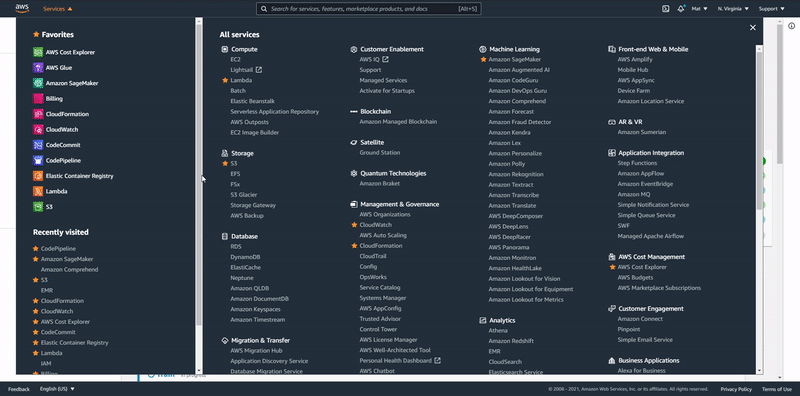

In [19]:
from IPython.display import Image
Image(filename='../imgs/loadpipeline.gif')

### Once the pipeline training process and deploy process our complete, we can test our deployed Dev endpoint

Lets create use the test data we separated for evaluation, and run predictions on all 333 customers to generate the probability of each customer churning.

In [23]:
test_data = pd.read_csv('test_data.csv')

In [24]:
sess = sagemaker.Session()
xgb_predictor = sagemaker.predictor.Predictor('pipeline-development', sagemaker_session=sess, serializer=CSVSerializer())

In [37]:
def predict(data, rows=2000):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.to_numpy()[:,1:])

In [43]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.where(predictions > 0.2, 1, 0), rownames=['actual'], colnames=['predictions'])

predictions    0   1
actual              
0.0          264  21
1.0            6  42

With the endpoint functioning properly, we can run any additional tests we'd like.
Once we're finished testing use the approval workflow on our pipeline to approve model deployment to our production endpoint:



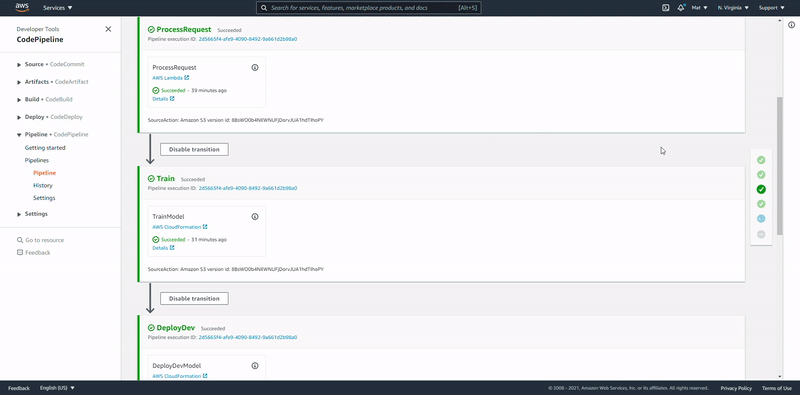

In [46]:
Image(filename='../imgs/pipelineapproval.gif')

Once our production endpoint is deployed we can run the same test to verify predictions with our test data:

In [47]:
xgb_predictor_prod = sagemaker.predictor.Predictor('pipeline-production', sagemaker_session=None, serializer=CSVSerializer())

In [48]:
def predict_prod(data, rows=2000):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor_prod.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')




In [49]:
predictions_prod = predict_prod(test_data.to_numpy()[:,1:])
predictions_prod


array([0.04594088, 0.04338237, 0.12121402, 0.04115116, 0.05016112,
       0.69511759, 0.04656969, 0.13465706, 0.04349471, 0.06287679,
       0.05450993, 0.04115116, 0.07602978, 0.05016112, 0.07992861,
       0.04376415, 0.04624721, 0.33008528, 0.04115116, 0.04624721,
       0.61024028, 0.0561538 , 0.04115116, 0.05498401, 0.10902666,
       0.04115116, 0.93427795, 0.04620972, 0.05279603, 0.04115116,
       0.07571053, 0.04349471, 0.04115116, 0.04338237, 0.63448483,
       0.04349471, 0.04115116, 0.05881285, 0.06918161, 0.04115116,
       0.10668433, 0.05279603, 0.04624721, 0.05202799, 0.81295007,
       0.04975453, 0.04115116, 0.05450993, 0.05256119, 0.04452354,
       0.05016112, 0.14879617, 0.05016112, 0.33982924, 0.04115116,
       0.04554102, 0.54581392, 0.04624721, 0.05240234, 0.22197875,
       0.04115116, 0.10079587, 0.04624721, 0.04656969, 0.04376415,
       0.04115116, 0.04115116, 0.07528707, 0.04624721, 0.04656969,
       0.31009188, 0.04115116, 0.08172955, 0.05162812, 0.67544

In [50]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.where(predictions_prod > 0.2, 1, 0), rownames=['actual'], colnames=['predictions'])

predictions    0   1
actual              
0.0          264  21
1.0            6  42

### Great! our prod end point is now functioning properly as well.

# A/B TESTING

If you take a look on the **deployment** parameters you'll see that we enabled the **Production** endpoint for A/B tests. 

To try this, we'll make some changes and reploy our model into production so we can compare predictions, 

For example sake, change some hyperparameter values in the hyperparamters section (try changing max depth to 10) and then run through the deployment cells again to start new pipeline training session.

When publishing the second model into **Development**, the endpoint will be updated and the model will be replaced without compromising the user experience. 
This is the natural behavior of an Endpoint in SageMaker when you update it.

After you approve the deployment into **Production**, the endponint will be updated and an **additional** model will be added to it. 

After the endpoint has successfully updated we can execute some **A/B tests**. 

Lets first setup a quick testing function:

In [62]:
from sagemaker.serializers import CSVSerializer
csv_serializer = CSVSerializer()
def test_endpoint(endpoint_name, payload):
    resp = sm.invoke_endpoint(
        EndpointName=endpoint_name,
        ContentType='text/csv',
        Accept='text/csv',
        Body=csv_serializer.serialize(payload)
    )
    variant_name = resp['ResponseMetadata']['HTTPHeaders']['x-amzn-invoked-production-variant']
    return float(resp['Body'].read().decode('utf-8').strip()), variant_name



Now you can execute the next cell a few times  to see the **Production** endpoint using both models A and B, respecting the proportion defined by the variable **InitialVariantWeight** in the deployment params.

In a real life scenario you can monitor the performance of both models and then adjust the **Weight** of each model to do the full transition to the new model (and remove the old one) or to rollback the new deployment.

In [87]:
%%time
payload = [118.000, 21.000, 156.500, 122.000, 209.200, 125.000, 158.700, 81.000, 11.100, 3.000, 4.000, 1.000, 0.000, 0.000, 0.000, 1.000, 0.000, 1.000]

print( "DSV")
print( "Classifier: %s, Variant Name: %s" % test_endpoint( endpoint_name_mask % ('development'), payload ) )

print( "PRD")
print( "Classifier: %s, Variant Name: %s" % test_endpoint( endpoint_name_mask % ('production'), payload ) )

DSV
Classifier: 0.6951175928115845, Variant Name: model-a
PRD
Classifier: 0.6951175928115845, Variant Name: model-a
CPU times: user 9.97 ms, sys: 0 ns, total: 9.97 ms
Wall time: 32.3 ms


To adjust the weight of each model (Variant Name) in an endpoint you can easily update the endpoint runtime settings in the sagemaker dashboard:

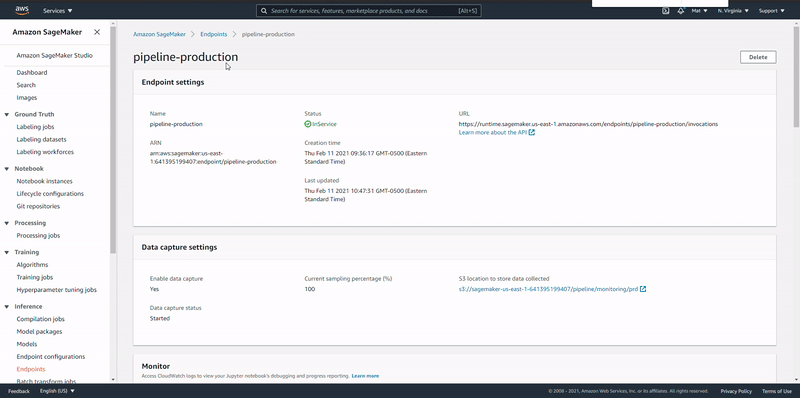

In [88]:
Image(filename='../imgs/updateweights.gif')

## AutoScaling Policies for our Production Endpoint

Finally, with the production endpoint now set up, we can also easily set up auto-scaling from the Sagemaker dashboard.

With a initial instance count of 2 for our A/B test models, lets set our max instance count to 10, and set the scaling policy of 700 invokations per instance, per minute. 

In that case, if any of our instances recieve more than 700 invocations in a given minute, our auto-scaling policy will automatically scale out and create new instances.


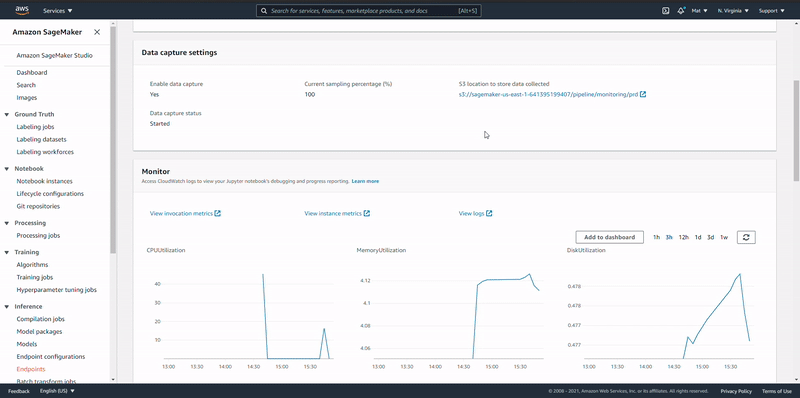

In [90]:
Image(filename='../imgs/autoscaling.gif')